In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/jul2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42285 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:42285/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:42285/status,Workers: 8
Total threads: 56,Total memory: 251.63 GiB
Comm: tcp://127.0.0.1:46192,Workers: 8
Dashboard: http://127.0.0.1:42285/status,Total threads: 56
Started: Just now,Total memory: 251.63 GiB
Comm: tcp://127.0.0.1:46672,Total threads: 7
Dashboard: http://127.0.0.1:37252/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:45366,


In [2]:
import numpy as np
import xarray as xr
import qgutils
import os.path as op
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
U = .1
nl = 3
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1563.
# f0 = 8e-5
beta = .5
N = 512    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

In [4]:
ddir = '/store/tuchida/msom/msqg/filter/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [5]:
psi = np.transpose(np.fromfile(op.join(ddir,'N512/psipg_4l_N512.bas'), dtype='f4').reshape((4,513,513)),(0,2,1))
rd = np.transpose(np.fromfile(op.join(ddir,'N512/rdpg_4l_N512.bas'), dtype='f4').reshape((513,513)),(1,0))
psi.shape

(4, 513, 513)

In [40]:
((rd[1:,40][:,np.newaxis] - 25e3/Rd/4.5)/40.*np.arange(40)).shape

(512, 40)

In [9]:
16*dx*Rd*1e-3

125.0

In [19]:
rd_adjust = rd.copy()
# rd_adjust[1:,1:16] = (rd[1:,16][:,np.newaxis] - 25e3/Rd/4.5)/(16.-1)*np.arange(16-1) + 25e3/Rd/4.5
rd_adjust[1:,1:16] = (rd[1:,16][:,np.newaxis] - 3.5)/(16.-1)*np.arange(16-1) + 3.5

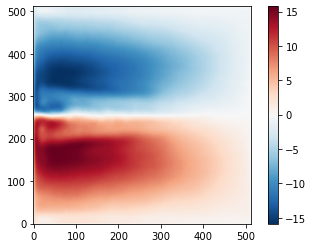

In [33]:
plt.imshow(psi[0,1:,1:], origin='lower', cmap='RdBu_r')
plt.colorbar()

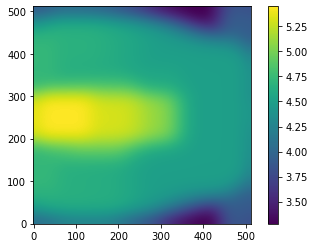

In [13]:
plt.imshow(rd[1:,1:], origin='lower')
plt.colorbar()

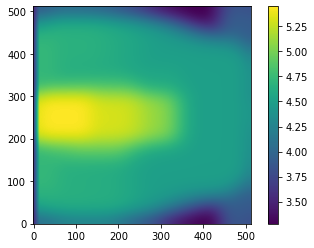

In [20]:
plt.imshow(rd_adjust[1:,1:], origin='lower')
plt.colorbar()

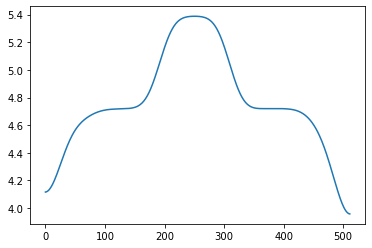

In [12]:
plt.plot(rd_adjust[1:,16])

In [40]:
xrpsi = xr.DataArray(psi[:,1:,1:], dims=['z','y','x'],
                     coords={'z':range(4),'y':range(512),'x':range(512)}
                    )
psi_2 = xrpsi.coarsen(y=2, x=2, boundary='exact').mean()
psi_4 = xrpsi.coarsen(y=4, x=4, boundary='exact').mean()
psi_4

<xarray.DataArray (z: 4, y: 128, x: 128)>
array([[[ 8.5745263e-01,  1.3039477e+00,  1.1228584e+00, ...,
          1.9267434e-01,  1.6755022e-01,  8.4817655e-02],
        [ 1.3932912e+00,  1.9489479e+00,  1.4920781e+00, ...,
          4.0203151e-01,  3.7128776e-01,  1.9689360e-01],
        [ 1.4007566e+00,  1.9122026e+00,  1.4377968e+00, ...,
          5.2977508e-01,  4.9408907e-01,  2.6457170e-01],
        ...,
        [-1.3411849e+00, -1.8375868e+00, -1.3608620e+00, ...,
         -5.3480685e-01, -5.0648212e-01, -2.7950925e-01],
        [-1.3184482e+00, -1.8575389e+00, -1.4199529e+00, ...,
         -4.1584975e-01, -3.9085758e-01, -2.0990510e-01],
        [-8.1481934e-01, -1.2561501e+00, -1.0681119e+00, ...,
         -2.0227969e-01, -1.7901461e-01, -8.7562658e-02]],

       [[-4.0958609e-02, -1.5129748e-01, -3.3074653e-01, ...,
         -5.0427265e-02, -4.7382139e-02, -2.2208890e-02],
        [-6.0829066e-02, -2.8857660e-01, -7.0237362e-01, ...,
         -1.6094027e-02, -2.9465929e-02, -3.0868426e-02],
        [-8.7937251e-02, -3.7399518e-01, -8.4675908e-01, ...,
          3.8766537e-02,  6.4726342e-03, -3.0778335e-02],
...
        [ 8.5452557e-01,  1.8945282e+00,  2.4507496e+00, ...,
          2.3948394e-02,  1.9740745e-02,  1.1338573e-02],
        [ 7.8457689e-01,  1.6931497e+00,  2.1370535e+00, ...,
          3.5916448e-02,  2.3633339e-02,  1.0330062e-02],
        [ 3.9158124e-01,  8.3645141e-01,  1.0181406e+00, ...,
          2.4354532e-02,  1.5995070e-02,  6.8243677e-03]],

       [[-3.7296474e-01, -8.1418431e-01, -9.9646616e-01, ...,
         -1.1130381e-02, -4.3839710e-03,  9.1704028e-04],
        [-7.6545930e-01, -1.6910169e+00, -2.1415203e+00, ...,
         -1.8924743e-02, -8.6010909e-03, -2.0670117e-04],
        [-8.4211779e-01, -1.9067250e+00, -2.4706855e+00, ...,
         -1.1448506e-02, -6.2490623e-03, -1.6270677e-04],
        ...,
        [ 8.6688328e-01,  1.9451456e+00,  2.5064216e+00, ...,
          2.7478302e-02,  1.9493025e-02,  9.0334350e-03],
        [ 7.9372197e-01,  1.7339369e+00,  2.1804175e+00, ...,
          3.6633428e-02,  2.1886699e-02,  8.4152054e-03],
        [ 3.9123896e-01,  8.4214467e-01,  1.0229224e+00, ...,
          2.2453211e-02,  1.3409179e-02,  5.4737646e-03]]], dtype=float32)
Coordinates:
  * z        (z) int64 0 1 2 3
  * y        (y) float64 1.5 5.5 9.5 13.5 17.5 ... 493.5 497.5 501.5 505.5 509.5
  * x        (x) float64 1.5 5.5 9.5 13.5 17.5 ... 493.5 497.5 501.5 505.5 509.5

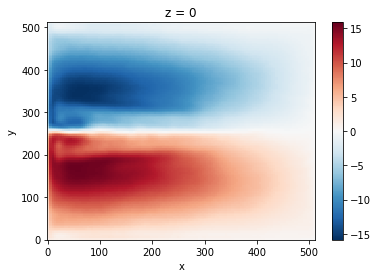

In [65]:
psi_4.isel(z=0).plot()

In [47]:
Nz, Ny, Nx = psi_2.shape
p_bas = np.zeros((Nz,Ny+1,Nx+1))
p_bas[:,1:,1:] = psi_2.data
p_bas[:,0,0] = Ny
p_bas = np.transpose(p_bas, (0,2,1))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
p_bas.astype('f4').tofile(ddir+'N256/psipg_4l_N256.bas')

In [49]:
Nz, Ny, Nx = psi_4.shape
p_bas = np.zeros((Nz,Ny+1,Nx+1))
p_bas[:,1:,1:] = psi_4.data
p_bas[:,0,0] = Ny
p_bas = np.transpose(p_bas, (0,2,1))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
p_bas.astype('f4').tofile(ddir+'N128/psipg_4l_N128.bas')

In [21]:
# xrrd = xr.DataArray(rd[1:,1:], dims=['y','x'],
#                     coords={'y':range(512),'x':range(512)}
#                    )
# rd_2 = xrrd.coarsen(y=2, x=2, boundary='exact').mean()
xrrd = xr.DataArray(rd_adjust[1:,1:], dims=['y','x'],
                    coords={'y':range(512),'x':range(512)}
                   )
rd_4 = xrrd.coarsen(y=4, x=4, boundary='exact').mean()
rd_4

<xarray.DataArray (y: 128, x: 128)>
array([[3.5617845, 3.7265427, 3.8913012, ..., 3.8288817, 3.8250206,
        3.8229125],
       [3.5629838, 3.7309403, 3.8988974, ..., 3.8312173, 3.8274202,
        3.8253472],
       [3.5653005, 3.739436 , 3.9135711, ..., 3.8356736, 3.8320003,
        3.8299952],
       ...,
       [3.5501397, 3.6838455, 3.8175514, ..., 3.8411791, 3.8387456,
        3.837388 ],
       [3.5474143, 3.673853 , 3.8002915, ..., 3.8349018, 3.8323822,
        3.830976 ],
       [3.5460033, 3.6686802, 3.791357 , ..., 3.8315594, 3.8289955,
        3.8275642]], dtype=float32)
Coordinates:
  * y        (y) float64 1.5 5.5 9.5 13.5 17.5 ... 493.5 497.5 501.5 505.5 509.5
  * x        (x) float64 1.5 5.5 9.5 13.5 17.5 ... 493.5 497.5 501.5 505.5 509.5

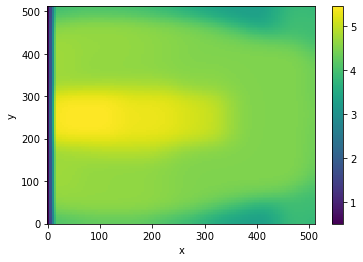

In [15]:
rd_4.plot()

In [53]:
Ny, Nx = rd_2.shape
r_bas = np.zeros((Ny+1,Nx+1))
r_bas[1:,1:] = rd_2.data
r_bas[0,0] = Ny
r_bas = np.transpose(r_bas, (1,0))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
r_bas.astype('f4').tofile(ddir+'N256/rdpg_4l_N256.bas')

In [22]:
Ny, Nx = rd_4.shape
r_bas = np.zeros((Ny+1,Nx+1))
r_bas[1:,1:] = rd_4.data
r_bas[0,0] = Ny
r_bas = np.transpose(r_bas, (1,0))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
r_bas.astype('f4').tofile(ddir+'N128/rdpg_4l_N128.bas')

# Outputs

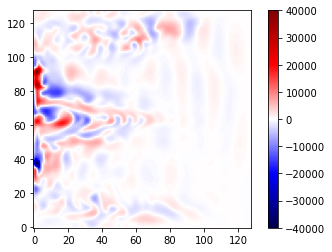

In [7]:
psi = np.transpose(np.fromfile(op.join(ddir,'N128/outdir_0013/po000596410.bas'), dtype='f4').reshape((4,129,129)),(0,2,1))
plt.imshow(psi[0,1:,1:]*U*Rd, origin='lower',  cmap='seismic', vmax=4e4, vmin=-4e4)
plt.colorbar()

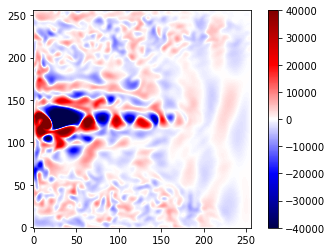

In [6]:
psi = np.transpose(np.fromfile(op.join(ddir,'N256/outdir_0013/po000390610.bas'), dtype='f4').reshape((4,257,257)),(0,2,1))
plt.imshow(psi[0,1:,1:]*U*Rd, origin='lower',  cmap='seismic', vmax=4e4, vmin=-4e4)
plt.colorbar()

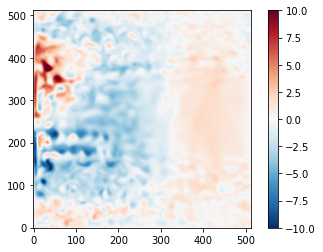

In [13]:
psi = np.transpose(np.fromfile(op.join(ddir,'LfullHeddy/outdir_0006/po001969810.bas'), dtype='f4').reshape((4,513,513)),(0,2,1))
plt.imshow(psi[0,1:,1:], origin='lower',  cmap='RdBu_r', vmax=10, vmin=-10)
plt.colorbar()

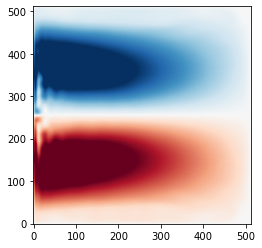

In [21]:
plt.imshow(np.transpose(np.fromfile(op.join(ddir,'LfullHeddy/psipg_4l_N512.bas'), dtype='f4').reshape((4,513,513)),(0,2,1))[0,1:,1:],
           vmax=1e1, vmin=-1e1, origin='lower', cmap='RdBu_r')